### I have embarked on a project to explore the difference between investing in ETFs vs individual stocks

The goal of this project is to eventually create an application that houses all of an individual's investment accounts, with the ability to compare against benchmarks, and also visualize predicted gains for retirement, showing the importance of investing early and often.


In [504]:
# Importing initial libraries.
import pandas as pd
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import bs4
import requests
from bs4 import BeautifulSoup
from pandas_datareader import data, wb
%matplotlib inline

I wanted to explore the idea of getting data via webscraping, since both the Yahoo Finance API and the Google Finance API were deprecated 

### Webscraping for Ticker Info

#### First I will use a single security, VTI in this instance, to make sure I am pulling the data correctly

In [489]:
r = requests.get('https://finance.yahoo.com/quote/VTI?p=VTI')

In [490]:
soup = bs4.BeautifulSoup(r.text, "lxml") 
#I originally had this as XML, but it broke for some reason.  A switch to LXML quickly fixed this.

In [491]:
#using the inspect aspect of a webpage, this is simply parsong a little HTML.  
soup.find_all(name = 'div', attrs = {'class':'My(6px) Pos(r) smartphone_Mt(6px)'})[0].find('span').text

'150.63'

### Creating a Function
#### Here I create a function that allows you to pass any ticker symbol into it and retrieve the current price from yahoo finance's webpage

In [492]:
def parseCurrentPrice(stock):
    r = requests.get('https://finance.yahoo.com/quote/{}?p={}'.format(stock,stock))
    soup = bs4.BeautifulSoup(r.text, "lxml")
    price = soup.find_all(name = 'div', attrs = {'class':'My(6px) Pos(r) smartphone_Mt(6px)'})[0].find('span').text
    return print('The current price of ' + str(stock).upper() + ' is: ' + str(price))

In [493]:
parseCurrentPrice('fb')
#boom! 

The current price of FB is: 184.19


#### I will now try to capture historic data for tickers

In [494]:
#create an empty list to add data to.
date_list=[]
high_list=[]
adjclose_list=[]

In [495]:
r2 = requests.get('https://finance.yahoo.com/quote/VTI/history?p=VTI')
soup2 = bs4.BeautifulSoup(r2.text, "lxml")
#below I was exploring the ability to change the intervals displayed on the page to show more days
#https://finance.yahoo.com/quote/VTI/history?period1=992588400&period2=1570258800&interval=1d&filter=history&frequency=1d

In [496]:
soup2.find(name = 'tr', attrs = {'class':'BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)'}) \
     .find(name = 'td', attrs = {'class': 'Py(10px) Ta(start) Pend(10px)'}).find('span').text

'Oct 11, 2019'

In [497]:
tr = soup2.find_all(name = 'tr', attrs = {'class':'BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)'})
#the above code sets the variable tr to the HTML element that holds every days' information.  Use find_all to capture every day
#the below function will iterate through every day and pull elements out related to the date
for row in tr:
    date_list.append(row.find(name = 'td', attrs = {'class': 'Py(10px) Ta(start) Pend(10px)'}).find('span').text)

In [498]:
#A quick check of the list shows we have successfully filled date_list with the dates corresponding to the market being open
date_list[0:5]

['Oct 11, 2019',
 'Oct 10, 2019',
 'Oct 09, 2019',
 'Oct 08, 2019',
 'Oct 07, 2019']

At this point, I tried to run the same function iterating through every day to collect data on the high and adjusted close of each day by adding the following lines to my `for row in tr` function:
- high_list.append(row.find_all(name = 'td')[0].text)
- adjclose_list.append(row.find_all(name = 'td')[4].text)

but I kept running into an error stating the list index out of range.  I realized the issue is with the dividends.  Whenever there was a dividend issued, there would not be highs, lows, and closing values.

I tried creating logic that would remove the dividends by finding the specific HTML elements that represented a dividend, and adding logic to only add the days where that element was empty, but got stuck.

The following code represents a dividend day:

```date_list.append(row.find_all(name = 'td', attrs = {'class': 'Ta(c) Py(10px) Pstart(10px)'}))```

      if row.find_all(name = 'td', attrs = {'class': 'Ta(c) Py(10px) Pstart(10px)'}) != '' :
        date_list.append(row.find_all(name = 'td', attrs = {'class': 'Ta(c) Py(10px) Pstart(10px)'}))
        high_list.append(row.find_all(name = 'td')[0].text)
        adjclose_list.append(row.find_all(name = 'td')[4].text)

#### At this point, I started to explore beyond Yahoo Finance for historical data, so see if another site's HTML was easier to parse

In [469]:
date_list2 = []
r3 = requests.get('https://seekingalpha.com/symbol/VTI/historical-price-quotes')
soup3 = bs4.BeautifulSoup(r3.text, "xml")

In [470]:
soup3.find('table').find_all('tr')

[<tr><th class="quote-date" data-sort="Date" data-type="date">Date</th><th class="quote-open" data-sort="Open">Open</th><th class="quote-high" data-sort="High">High</th><th class="quote-low" data-sort="Low">Low</th><th class="quote-close" data-sort="Close">Close</th><th class="quote-volume" data-sort="Volume">Volume</th><th class="quote-change" data-sort="PercentChange">Change %</th></tr>]

In [471]:
tr2 = soup3.find('table').find('tr').find('th').text
tr2

'Date'

#### We will come back to that attempt.

### I will now attempt to have my program download a csv and read it for historical data

In [499]:
from selenium import webdriver

In [501]:
from webdriver_manager.chrome import ChromeDriverManager

driver = webdriver.Chrome(ChromeDriverManager().install())

driver.get('https://finance.yahoo.com/quote/VTI/history?p=VTI')


Checking for win32 chromedriver:77.0.3865.40 in cache
Driver found in C:\Users\ryanJ\.wdm\chromedriver\77.0.3865.40\win32/chromedriver.exe


In [502]:
download_data = driver.find_element_by_link_text('Download Data')
#download data is the HTML name of the button

download_data.click()
#click on the download data link

In [482]:
#downloaded it to the directory, now reading it from the CSV on my drive.
df = pd.read_csv('VTI.csv', index_col='Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-19,150.119995,150.479996,150.009995,150.149994,146.546326,1809800
2018-09-20,150.830002,151.470001,150.520004,151.309998,147.678497,1713900
2018-09-21,151.820007,151.839996,151.050003,151.160004,147.532104,1986100
2018-09-24,150.869995,150.929993,150.270004,150.610001,146.995300,1668600
2018-09-25,150.889999,151.070007,150.419998,150.529999,146.917206,2318900


I realized I need to write a function to have it overwrite the CSV, or have create a variable that increments.

In [503]:
def incrementer(): 
    csv = str(VTI.csv(x))


'VTI.csv'

In the meantime, I continued with selenium to find the elements by the HTML path

In [485]:
driver.find_element_by_xpath('// tr[@class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"]').text

'Oct 11, 2019 150.51 151.90 150.47 150.63 150.63 3,373,445'

In [486]:
driver.find_element_by_xpath('// tr[@class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"]/td').text

'Oct 11, 2019'

In [505]:
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2019, 10, 1)

In [506]:
VTI = data.DataReader("VTI", 'stooq', '2015-01-01', end)
VXUS = data.DataReader("VXUS", 'stooq', '2015-01-01', end)
BND = data.DataReader("BND", 'stooq', '2015-01-01', end)
AAPL = data.DataReader("AAPL", 'stooq', '2015-01-01', end)
FB = data.DataReader("FB", 'stooq', '2015-01-01', end)

In [508]:
VXUS.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-10-11,52.00,52.3850,52.000,52.12,1816338
2019-10-10,50.97,51.3533,50.910,51.30,1809435
2019-10-09,50.87,51.0000,50.780,50.92,1151910
2019-10-08,50.69,50.7800,50.489,50.52,1762690
2019-10-07,51.02,51.2050,50.945,50.95,1164371


In [509]:
tickers = ['AAPL', 'BND', 'FB', 'VTI', 'VXUS']

In [510]:
bank_stocks = pd.concat([AAPL, BND, FB, VTI, VXUS], axis=1, keys=tickers)
bank_stocks.head()

AAPL                                          BND          \
              Open    High     Low   Close       Volume    Open    High   
Date                                                                      
2010-01-04  26.617  26.743  26.480  26.682  140770684.0  61.723  61.829   
2010-01-05  26.779  26.878  26.587  26.728  172276576.0  61.955  62.042   
2010-01-06  26.728  26.833  26.274  26.301  157573183.0  62.019  62.026   
2010-01-07  26.391  26.431  26.063  26.254  136473074.0  61.820  61.940   
2010-01-08  26.234  26.431  26.065  26.430  128121016.0  61.947  62.010   

                                       ...       VTI                          \
               Low   Close     Volume  ...      Open    High     Low   Close   
Date                                   ...                                     
2010-01-04  61.677  61.787  1392062.0  ...    48.362  48.807  48.346  48.746   
2010-01-05  61.875  61.972  1032642.0  ...    48.772  48.941  48.576  48.933   
2010-01-06  61.803  61.947  1243977.0  ...    48.906  49.092  48.833  49.002   
2010-01-07  61.820  61.900   838786.0  ...    48.950  49.241  48.729  49.207   
2010-01-08  61.858  61.964  1609980.0  ...    49.077  49.376  48.958  49.368   

                      VXUS                        
               Volume Open High Low Close Volume  
Date                                              
2010-01-04  2647120.0  NaN  NaN NaN   NaN    NaN  
2010-01-05  1878318.0  NaN  NaN NaN   NaN    NaN  
2010-01-06  2492687.0  NaN  NaN NaN   NaN    NaN  
2010-01-07  1947683.0  NaN  NaN NaN   NaN    NaN  
2010-01-08  1939899.0  NaN  NaN NaN   NaN    NaN  

[5 rows x 25 columns]

In [511]:
bank_stocks.columns.names = ['Bank Ticker','Stock Info']
bank_stocks.dropna(thresh=21, inplace=True)
bank_stocks.head()

Bank Ticker    AAPL                                          BND          \
Stock Info     Open    High     Low   Close       Volume    Open    High   
Date                                                                       
2012-05-18   66.571  67.750  65.101  66.124  209689469.0  69.276  69.389   
2012-05-21   66.638  70.008  66.581  69.978  183267780.0  69.343  69.359   
2012-05-22   71.009  71.547  68.892  69.439  198918773.0  69.262  69.262   
2012-05-23   69.507  71.412  68.970  71.133  168420448.0  69.276  69.336   
2012-05-24   71.796  71.874  69.972  70.477  122920984.0  69.248  69.268   

Bank Ticker                               ...        VTI                  \
Stock Info      Low   Close     Volume    ...       Open    High     Low   
Date                                      ...                              
2012-05-18   69.248  69.309  1263255.0    ...     58.542  58.682  57.741   
2012-05-21   69.294  69.318  2764152.0    ...     58.020  58.918  57.882   
2012-05-22   69.129  69.206  1932864.0    ...     59.013  59.449  58.596   
2012-05-23   69.255  69.255  1477976.0    ...     58.552  59.125  57.965   
2012-05-24   69.181  69.181   935116.0    ...     59.179  59.281  58.636   

Bank Ticker                       VXUS                                    
Stock Info    Close     Volume    Open    High     Low   Close    Volume  
Date                                                                      
2012-05-18   57.847  4984189.0  32.626  32.740  32.305  32.312  143731.0  
2012-05-21   58.918  2494360.0  32.473  33.006  32.473  32.933  158493.0  
2012-05-22   58.936  2190585.0  32.973  33.226  32.684  32.839   94190.0  
2012-05-23   59.037  2040456.0  32.501  32.578  31.947  32.578  109920.0  
2012-05-24   59.152  1014540.0  32.618  32.660  32.199  32.433   89159.0  

[5 rows x 25 columns]

In [512]:
for tick in tickers:
    print(str(tick) + ' ' + str(bank_stocks[tick]['Close'].max()))

AAPL 236.21
BND 84.968
FB 217.5
VTI 153.71
VXUS 58.207


In [513]:
bank_stocks.xs(key='Close',axis=1,level='Stock Info').max()

Bank Ticker
AAPL    236.210
BND      84.968
FB      217.500
VTI     153.710
VXUS     58.207
dtype: float64

** Create a new empty DataFrame called returns. This dataframe will contain the returns for each bank's stock. returns are typically defined by:**

$$r_t = \frac{p_t - p_{t-1}}{p_{t-1}} = \frac{p_t}{p_{t-1}} - 1$$

In [515]:
returns = pd.DataFrame()

In [516]:
for tick in tickers:
    returns[tick + ' Return'] = bank_stocks[tick]['Close'].pct_change()
returns.head()

,AAPL Return,BND Return,FB Return,VTI Return,VXUS Return
Date,,,,,
2012-05-18,NaN,NaN,NaN,NaN,NaN
2012-05-21,0.058284,0.000130,-0.109861,0.018514,0.019219
2012-05-22,-0.007702,-0.001616,-0.089039,0.000306,-0.002854
2012-05-23,0.024396,0.000708,0.032258,0.001714,-0.007948
2012-05-24,-0.009222,-0.001069,0.032188,0.001948,-0.004451


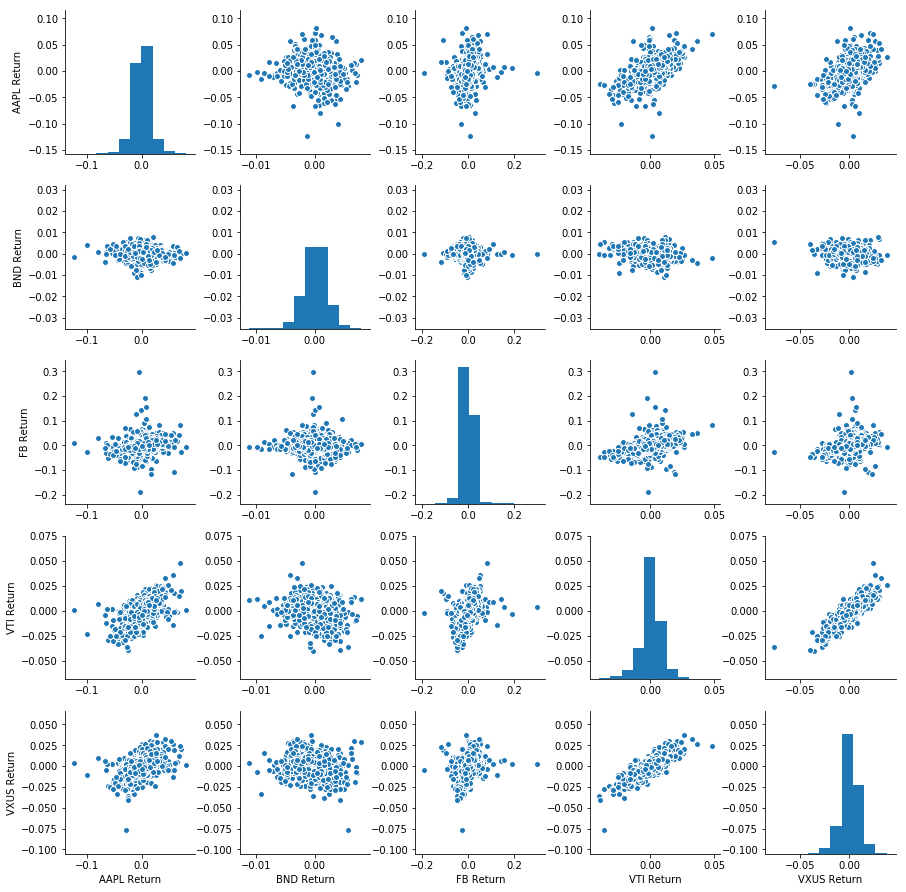

In [517]:
#returns[1:]
import seaborn as sns
sns.pairplot(returns[1:])

In [518]:
# Worst Drop 
returns.idxmin()
# returns.min()

AAPL Return   2013-01-24
BND Return    2013-07-05
FB Return     2018-07-26
VTI Return    2015-08-24
VXUS Return   2016-06-24
dtype: datetime64[ns]

In [519]:
returns.idxmax()

AAPL Return   2014-04-24
BND Return    2013-09-18
FB Return     2013-07-25
VTI Return    2018-12-26
VXUS Return   2012-06-29
dtype: datetime64[ns]

In [520]:
returns.std()

AAPL Return    0.016047
BND Return     0.002011
FB Return      0.023017
VTI Return     0.008251
VXUS Return    0.009085
dtype: float64

In [521]:
returns.loc['2015-01-01':'2015-12-31'].std()

AAPL Return    0.016805
BND Return     0.002338
FB Return      0.016173
VTI Return     0.009581
VXUS Return    0.010567
dtype: float64

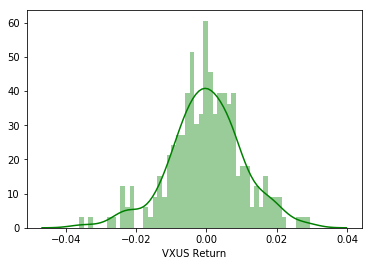

In [523]:
sns.distplot(returns.ix['2015-01-01':'2015-12-31']['VXUS Return'],color='green',bins=50)

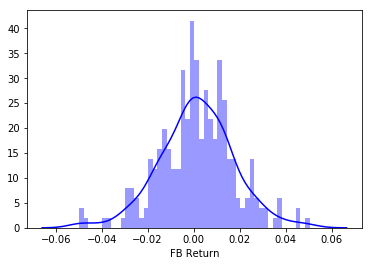

In [524]:
sns.distplot(returns.ix['2015-01-01':'2015-12-31']['FB Return'],color='blue',bins=50)

In [525]:
# Optional Plotly Method Imports
import plotly
import cufflinks as cf
cf.go_offline()

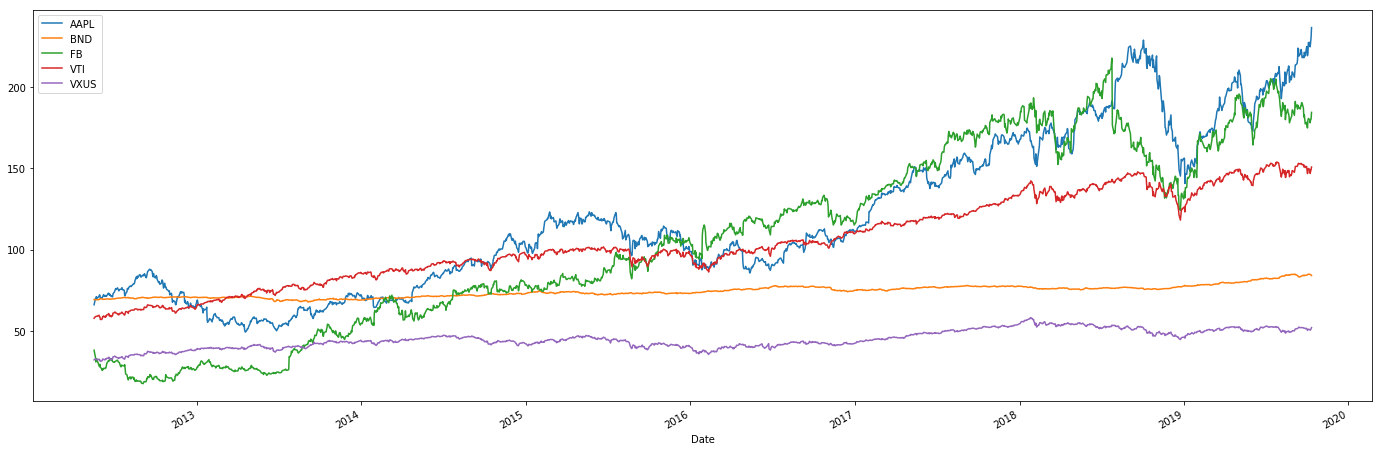

In [526]:
for tick in tickers:
    bank_stocks[tick]['Close'].plot(figsize=(24,8),label=tick)
plt.legend()

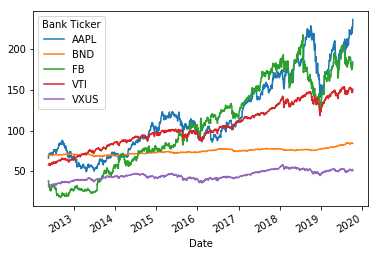

In [529]:
bank_stocks.xs(key='Close',axis=1,level='Stock Info').plot()

In [530]:
bank_stocks.xs(key='Close',axis=1,level='Stock Info').iplot()